# Hotspot tracking movie maker

First, import all necessary packages:

In [1]:
# Import all packages and modules
import pygplates
import numpy as np
import sys
sys.path.append('../libs/')
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
%matplotlib inline

print('Everything successfully loaded.')

Everything successfully loaded.


Below, we define a series of functions that are used successviely to obtain a velocity vector field. This code is sourced from [Plate Tectonic Tools](https://github.com/EarthByte/PlateTectonicTools/blob/master/ptt/velocity_tools.py).

In [2]:
# Code to obtain velocity vector field

# Takes the longitude and latitude, which are the flattened outputs of meshgrid(Xnodes,Ynodes), and returns a 
# feature collection. 
def make_GPML_velocity_feature(Long,Lat):
    
# function to make a velocity mesh nodes at an arbitrary set of points defined in Lat
# Long and Lat are assumed to be 1d arrays. 

    # Obtain lat-lon pairs, format to floating-point and add them to a multipoint geometry
    multi_point = pygplates.MultiPointOnSphere([(float(lat),float(lon)) for lat, lon in zip(Lat,Long)])

    # Create a feature containing the multipoint feature, and defined as MeshNode type
    meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
    meshnode_feature.set_geometry(multi_point)
    meshnode_feature.set_name('Velocity Mesh Nodes from pygplates')

    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    # NB: at this point, the feature could be written to a file using
    # output_feature_collection.write('myfilename.gpmlz')
    
    # for use within the notebook, the velocity domain feature is returned from the function
    return output_feature_collection



# function to get velocites via pygplates. Returns the array of tuples "all_velocities" containing
# (magnitude, azimuth, inclination)
def get_plate_velocities(velocity_domain_features, topology_features, 
                         rotation_model, time, delta_time, rep='vector_comp'):
    # All domain points and associated (magnitude, azimuth, inclination) velocities for the current time.
    all_domain_points = []
    all_velocities = []

    # Partition our velocity domain features into our topological plate polygons at the current 'time'.
    plate_partitioner = pygplates.PlatePartitioner(topology_features, rotation_model, time)
    for velocity_domain_feature in velocity_domain_features:
        # A velocity domain feature usually has a single geometry but we'll assume it can be any number.
        # Iterate over them all.
        for velocity_domain_geometry in velocity_domain_feature.get_geometries():
            for velocity_domain_point in velocity_domain_geometry.get_points():
                all_domain_points.append(velocity_domain_point)
                partitioning_plate = plate_partitioner.partition_point(velocity_domain_point)
                if partitioning_plate:
                    # We need the newly assigned plate ID to get the equivalent stage rotation of that tectonic plate.
                    partitioning_plate_id = partitioning_plate.get_feature().get_reconstruction_plate_id()
                    # Get the stage rotation of partitioning plate from 'time + delta_time' to 'time'.
                    equivalent_stage_rotation = rotation_model.get_rotation(time, partitioning_plate_id, time + delta_time)

                    # Calculate velocity at the velocity domain point.
                    # This is from 'time + delta_time' to 'time' on the partitioning plate.
                    velocity_vectors = pygplates.calculate_velocities(
                        [velocity_domain_point],
                        equivalent_stage_rotation,
                        delta_time)
                    
                    if rep=='mag_azim':
                        # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                        velocities = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                            [velocity_domain_point],
                            velocity_vectors)
                        all_velocities.append(velocities[0])

                    elif rep=='vector_comp':
                        # Convert global 3D velocity vectors to local (magnitude, azimuth, inclination) tuples (one tuple per point).
                        velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                                [velocity_domain_point],
                                velocity_vectors)
                        all_velocities.append(velocities[0])
                else:
                    all_velocities.append((0,0,0))
    return all_velocities

def get_velocities(time,rotation_model,topology_filenames, delta_time = 5., Xnodes=[], Ynodes=[]):
    '''get velocity data
    
    Parameters
    ----------
    time: the reconstruction time
    rotation_model: the rotation model
    topology_filenames: the topology files
    delta_time: the time increment
    Xnodes, Ynodes: the coordinates of domain points
    
    Returns
    -------
    the coordinates of domain points and velocity data
    '''
    if len(Xnodes)==0 or len(Ynodes)==0:
        Xnodes = np.arange(-180,180,10)
        Ynodes = np.arange(-90,90,10)
    Xg,Yg = np.meshgrid(Xnodes,Ynodes)
    Xg = Xg.flatten()
    Yg = Yg.flatten()
    velocity_domain_features = make_GPML_velocity_feature(Xg,Yg)

    # Load the topological plate polygon features.
    topology_features = []
    for fname in topology_filenames:
        for f in pygplates.FeatureCollection(fname):
            topology_features.append(f)

    # Call the function we created above to get the velocities
    return Xnodes, Ynodes, get_plate_velocities(velocity_domain_features,
                                          topology_features,
                                          rotation_model,
                                          time,
                                          delta_time,
                                          'vector_comp')


def get_x_y_u_v(Xnodes, Ynodes, all_velocities):
    '''get velocity u,v components from velocity data
    
    Parameters
    ----------
    all_velocities: the velocity data
    Xnodes, Ynodes: the coordinates of domain points
    
    Returns
    -------
    the coordinates of domain points and velocity u, v components
    '''
    uu=[]
    vv=[]
    for vel in all_velocities:
        if not hasattr(vel, 'get_y'): 
            uu.append(vel[1])
            vv.append(vel[0])
        else:
            uu.append(vel.get_y())
            vv.append(vel.get_x())
    u = np.asarray([uu]).reshape((Ynodes.shape[0],Xnodes.shape[0]))
    v = np.asarray([vv]).reshape((Ynodes.shape[0],Xnodes.shape[0]))

    return Xnodes, Ynodes, u, v


def get_velocity_x_y_u_v(time,rotation_model,topology_filenames, delta_time = 5., Xnodes=[], Ynodes=[]):
    '''get velocity data in x ,y, u, v form
    
    Parameters
    ----------
    time: the reconstruction time
    rotation_model: the rotation model
    topology_filenames: the topology files
    delta_time: the time increment
    Xnodes, Ynodes: the coordinates of domain points
    
    Returns
    -------
    the coordinates of domain points and velocity u, v components
    '''
    Xnodes, Ynodes, all_velocities = get_velocities(time,rotation_model,topology_filenames,
                                                    delta_time = 5., Xnodes=Xnodes, Ynodes=Ynodes)
    return get_x_y_u_v(Xnodes, Ynodes, all_velocities)





# Functions to plot velocity fields either using u,v or velocity_Data

def plot_velocities_uv(x,y,u,v,ax, alpha, scale):
    '''draw the velocity vectors in a map
    Some arrows are long and some are very short. 
    To make the plot clearer, we nomalize the velocity magnitude and use color to denote the different speed.
    
    Parameters
    ----------
    x,y: the domain points coordinates
    u,v: the u and v component of the velocities
    ax: the matplotlib axes object
    
    Returns
    -------
    A colour bar object
    '''
    u = np.array(u)
    v = np.array(v)
    mag = np.sqrt(u*u+v*v)
    #mag[mag==0] = 1 #to avoid 0 divisor
    #u = u/mag
    #v = v/mag
    cb = ax.quiver(x, y, u, v, alpha=alpha, scale=scale, transform=ccrs.PlateCarree(),cmap='jet',zorder=100)    
    return cb


def plot_velocities(x,y,velocities,ax, alpha, scale):  
    '''draw the velocity vectors in a map
    Some arrows are long and some are very short. 
    To make the plot clearer, we nomalize the velocity magnitude and use color to denote the different speed.
    
    Parameters
    ----------
    x,y: the domain points coordinates
    velocities: the velocity data
    ax: the matplotlib axes object
    
    Returns
    -------
    A colour bar object
    '''
    # x_ and y_ actually turn out to be Xnodes and Ynodes too 
    x_,y_,u,v = get_x_y_u_v(x, y, velocities)
    return plot_velocities_uv(x_,y_,u,v,ax, alpha, scale)

We can use the functions above in another function, **plot_velocities_and_topologies**, which plots both the generated plate velocity fields and a series of resolved topological plate boundaries to a specific time. This function is defined below:

In [3]:
# Plot velocities and topologies function
def plot_velocities_and_topologies(pmap,
                                   topology_features,
                                   rotation_model,
                                   time,
                                   delta_time=5,
                                   res=10,
                                   scale=2000,
                                   lon0=0,
                                   clip_path=None,
                                   alpha=0.4,
                                   MidOceanRidge_alpha=0.4,
                                   SubductionZone_alpha=0.4,
                                   FractureZone_alpha=0.4,
                                   quiver_alpha=0.4,
                                   MidOceanRidge_color='r',
                                   SubductionZone_color='k',
                                   FractureZone_color='b',
                                   MidOceanRidge_linewidth=3,
                                   SubductionZone_linewidth=3,
                                   FractureZone_linewidth=3,
                                   ):

    # Manually generate X and Y nodes to represent lon-lat points on a global sphere, and run them through meshgrid
    Xnodes = np.arange(-180,180,res)
    Ynodes = np.arange(-90,90,res)
    Xg,Yg = np.meshgrid(Xnodes,Ynodes)

    # Flatten the meshgrid outputs into 1D arrays to obtain the domain feature collection
    velocity_domain_features = make_GPML_velocity_feature(Xg.flatten(),Yg.flatten())

    # Call the function we created above to get the velocities
    all_velocities = get_plate_velocities(velocity_domain_features,
                                          topology_features,
                                          rotation_model,
                                          time,
                                          delta_time,
                                          'vector_comp')
    
    # The rest of the cell is for plotting, including rendering resolved topological boundaries to the map
    pt_vel_n=[]
    pt_vel_e=[]
    for vel in all_velocities:
        pt_vel_e.append(vel.get_y())
        pt_vel_n.append(vel.get_x())
    
    u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
    v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))
        
    # Resolve our topological plate polygons (and deforming networks) to the current 'time'.
    # We generate both the resolved topology boundaries and the boundary sections between them.
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, float(time), shared_boundary_sections)
    
    # create a dateline wrapper object
    wrapper = pygplates.DateLineWrapper(lon0)
    
    # Iterate over the shared boundary sections.
    for shared_boundary_section in shared_boundary_sections:
    
        # The shared sub-segments contribute either to the ridges or to the subduction zones.
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('MidOceanRidge'):
            # Ignore zero length segments - they don't have a direction.
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
                for geometry in split_geometry:
                    X=[]
                    Y=[]
                    for point in geometry.get_points():
                        X.append(point.get_longitude()),Y.append(point.get_latitude())
                    #x,y = pmap(X,Y)
                    pmap.plot(X,Y,MidOceanRidge_color,clip_path=clip_path,linewidth=MidOceanRidge_linewidth,
                              alpha=MidOceanRidge_alpha, transform=ccrs.PlateCarree(), zorder=1)     
    
        elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
                for geometry in split_geometry:
                    X=[]
                    Y=[]
                    for point in geometry.get_points():
                        X.append(point.get_longitude()),Y.append(point.get_latitude())
                    #x,y = pmap(X,Y)
                pmap.plot(X,Y,SubductionZone_color,clip_path=clip_path,linewidth=SubductionZone_linewidth,
                          alpha=SubductionZone_alpha, transform=ccrs.PlateCarree(), zorder=1)  
    
        else: #shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('FractureZone'):
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
                for geometry in split_geometry:
                    X=[]
                    Y=[]
                    for point in geometry.get_points():
                        X.append(point.get_longitude()),Y.append(point.get_latitude())
                    #x,y = pmap(X,Y)
                pmap.plot(X,Y,FractureZone_color,clip_path=clip_path,linewidth=FractureZone_linewidth,
                          alpha=FractureZone_alpha, transform=ccrs.PlateCarree(), zorder=1)  
                
                
    # We have plotted the topologies of plate boundaries. Now plot the vector fields:
    plot_velocities(Xnodes, Ynodes, all_velocities, pmap, alpha, scale)

Here, we create one frame of the hotspot movie.

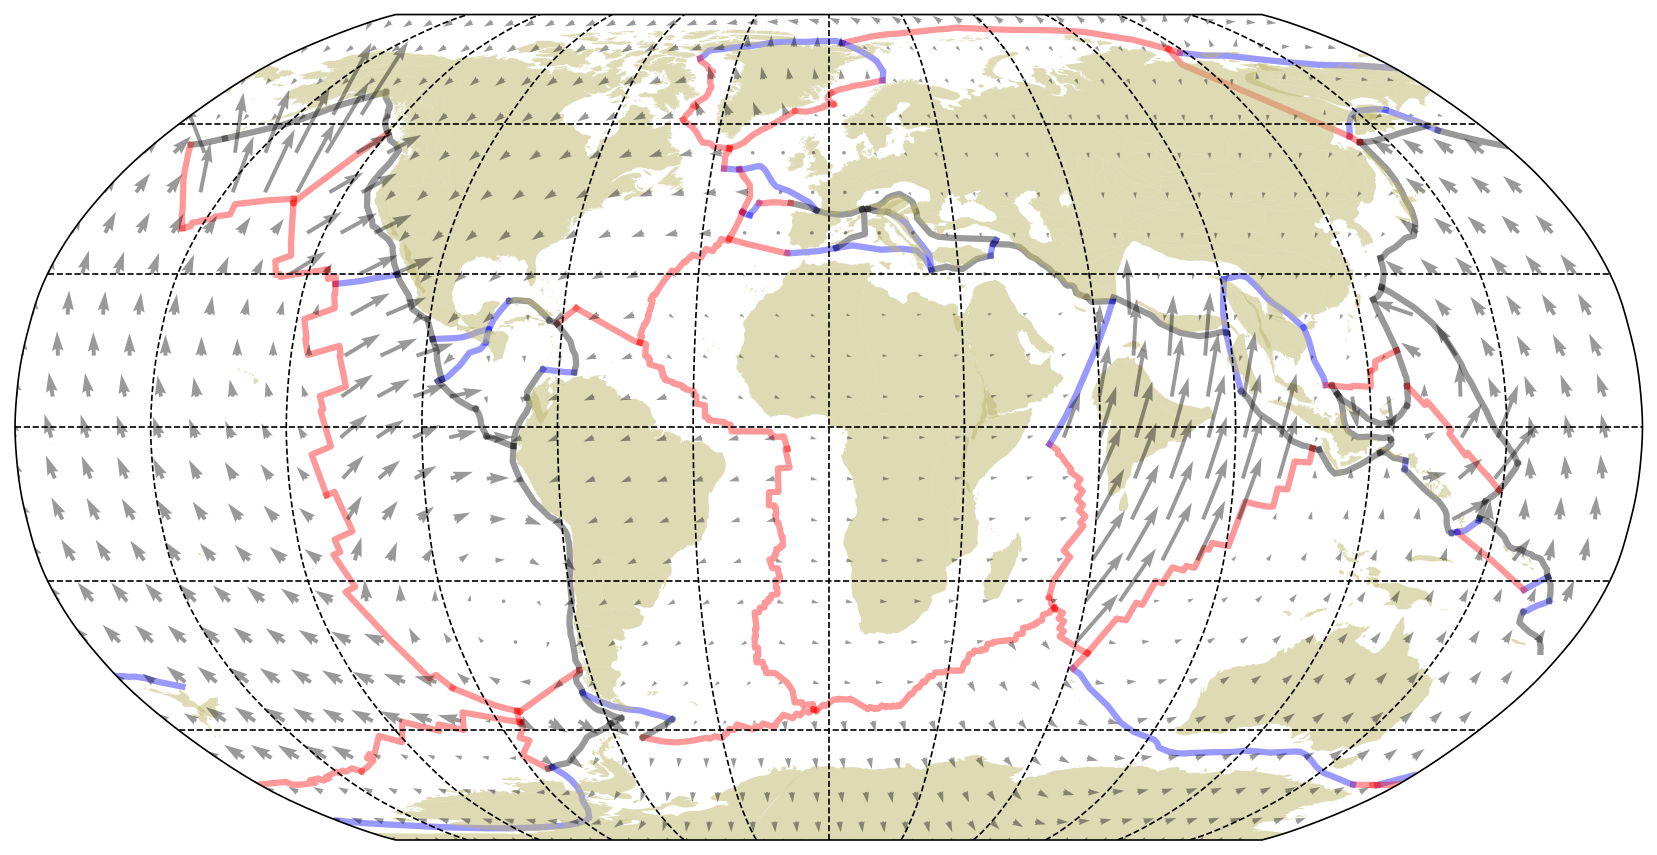

In [9]:
# Rotation and topology filenames
rotation_filename = 'Data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'
topology_features = ['Data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpmlz',\
             'Data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpmlz']

# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

# Reconstruction time
time=50

# Load the coastline gmpl file, and reconstruct it to the rotation model.
coastlines_file = 'Data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz'
pygplates.reconstruct(coastlines_file, rotation_model, '/tmp/tmp.shp', time, 1)

# Create the map plot, projection and set gridlines
fig = plt.figure(figsize=(14,10),dpi=150)
lon0=0
m = fig.add_subplot(111,projection=ccrs.Robinson(central_longitude=lon0))
m.gridlines(color='black',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))

# Plot the reconstructed coastlines from the coastline shapefile
shp_info = shpreader.Reader('/tmp/tmp.shp')
poly = cfeature.ShapelyFeature(shp_info.geometries(), crs=ccrs.PlateCarree())        
m.add_feature(poly, facecolor='DarkKhaki', edgecolor='none', alpha=0.5)

# Plot velocities and topologies using the function defined above
plot_velocities_and_topologies(m,topology_features,rotation_model,time,
                               delta_time=5,res=8,scale=4000,lon0=lon0)

# Set global extent and show plot
m.set_global()    
plt.show()

Next, we create several frames for reconstruction times 10 Ma, 8 Ma, 6 Ma, 4 Ma and 2 Ma, plotting resolved topologies and coastlines along with points that track the movements of particular plate seed points. Save these frames as png files.

In [17]:
#%%capture capt --no-stdout
time_step = 2.
oldest_seed_time = 10.

# Empty array for storing Long/Lat of 
point_longitude = []
point_latitude = []


# Location of seed point for Kerguelen
hs_geometry = []
# Seed point for Kerguelen
hs_geometry.append(pygplates.PointOnSphere(-49, 69))
# Seed point for Hawaii
hs_geometry.append(pygplates.PointOnSphere(19, -155))
# Seed point for Reunion
hs_geometry.append(pygplates.PointOnSphere(-17, 59))
# Seed point for Iceland
hs_geometry.append(pygplates.PointOnSphere(64, -17))
# Seed point for Tristan
hs_geometry.append(pygplates.PointOnSphere(-37, -12))
# Seed point for Louisville
hs_geometry.append(pygplates.PointOnSphere(-54, -141))
# Seed point for Afar
hs_geometry.append(pygplates.PointOnSphere(7, 39))
# Seed point for Samoa
hs_geometry.append(pygplates.PointOnSphere(-15, -168))
# Seed point for Easter
hs_geometry.append(pygplates.PointOnSphere(-27, -110))
# Seed point for Crozet
hs_geometry.append(pygplates.PointOnSphere(-46, 50))
# Seed point for Ascension
hs_geometry.append(pygplates.PointOnSphere(-8, -14))
# Seed point for Tahiti
hs_geometry.append(pygplates.PointOnSphere(-18, -148))
# Seed point for Azores
hs_geometry.append(pygplates.PointOnSphere(38, -28))
# Seed point for Yellowstone
hs_geometry.append(pygplates.PointOnSphere(44, -111))
  
point_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    
    print(f'working on time {time}')
    
    for hs_point in hs_geometry:
        point_list.append(hs_point)    

    # Get the plate polygons for this time
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

    # make plate partitioner from polygons
    plate_partitioner = pygplates.PlatePartitioner(resolved_topologies, rotation_model)

    new_point_list = []
    point_longitude = []
    point_latitude = []
    for seed_geometry in point_list:
    # Find the plate id of the polygon that contains the point
        polygon = plate_partitioner.partition_point(seed_geometry)
    
        PlateID = polygon.get_feature().get_reconstruction_plate_id()
        #print PlateID

        # Get the stage rotation that will move the point from where it is at the current time
        # to its location at the next time step, based on the plate id that contains the point at the 
        # current time
        stage_rotation = rotation_model.get_rotation(time-time_step, PlateID, time, anchor_plate_id=1)

        # use the stage rotation to reconstruct the tracked point from position at current time 
        # to position at the next time step
        seed_geometry = stage_rotation * seed_geometry
    
        point_longitude.append(seed_geometry.to_lat_lon_point().get_longitude())
        point_latitude.append(seed_geometry.to_lat_lon_point().get_latitude())
        
        new_point_list.append(seed_geometry)
        
    point_list = new_point_list
        
    #### Plotting
    pygplates.reconstruct(coastlines_file, rotation_model, '/tmp/tmp.shp', time, 1)

    fig = plt.figure(figsize=(15,10),dpi=150)
    lon0=0
    m = fig.add_subplot(111,projection=ccrs.Robinson(central_longitude=lon0))
    m.gridlines(color='black',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))
    m.add_feature(cfeature.OCEAN, color='white')

        
    # Plot reconstructed coastlines - filtering out small polygons by area may fix a coastline shapefile facecolor bug
    shp_info = shpreader.Reader('/tmp/tmp.shp').geometries()
    polygons=[]
    for geom in shp_info:
        if geom.area>1.5:
            polygons.append(geom)
    ft_coastline  = cfeature.ShapelyFeature(polygons, ccrs.PlateCarree())
    m.add_feature(ft_coastline, facecolor='DarkKhaki', edgecolor='none', alpha=0.5)

    # Plot plate velocity vectors and topological boundaries
    plot_velocities_and_topologies(m,topology_features,rotation_model,time,
                                   delta_time=5,res=8,scale=4000,lon0=lon0)

    # Plot point-trackers for the movements of several plate seed points
    for hs_point in hs_geometry:
        x,y = hs_point.to_lat_lon()[1],hs_point.to_lat_lon()[0]
        m.plot(x,y,'r*',markersize=20, transform=ccrs.PlateCarree(), zorder=1)
    
    x, y = point_longitude, point_latitude
    m.plot(x,y,'.',markersize=10, transform = ccrs.PlateCarree(), zorder=1)
    
    
    plt.title('Time = %d Ma' % time)
    m.set_global()    
    #plt.show()
    
    plt.savefig('/tmp/plume_product_tracker_%d_Ma.png' % time)
    plt.close()
    
    print('Image for %d Ma saved' % time)

working on time 10.0
Image for 10 Ma saved
working on time 8.0
Image for 8 Ma saved
working on time 6.0
Image for 6 Ma saved
working on time 4.0
Image for 4 Ma saved
working on time 2.0
Image for 2 Ma saved


If moviepy is available, you can try creating a gif (or other animation format) from the sequence of images generated in the above cell.

In [18]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/plume_product_tracker_%d_Ma.png' % time)
    

clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/hotspot_trails.gif')

t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]

MoviePy - Building file /tmp/hotspot_trails.gif with imageio.


The movie will show up in a few seconds. Please be patient...


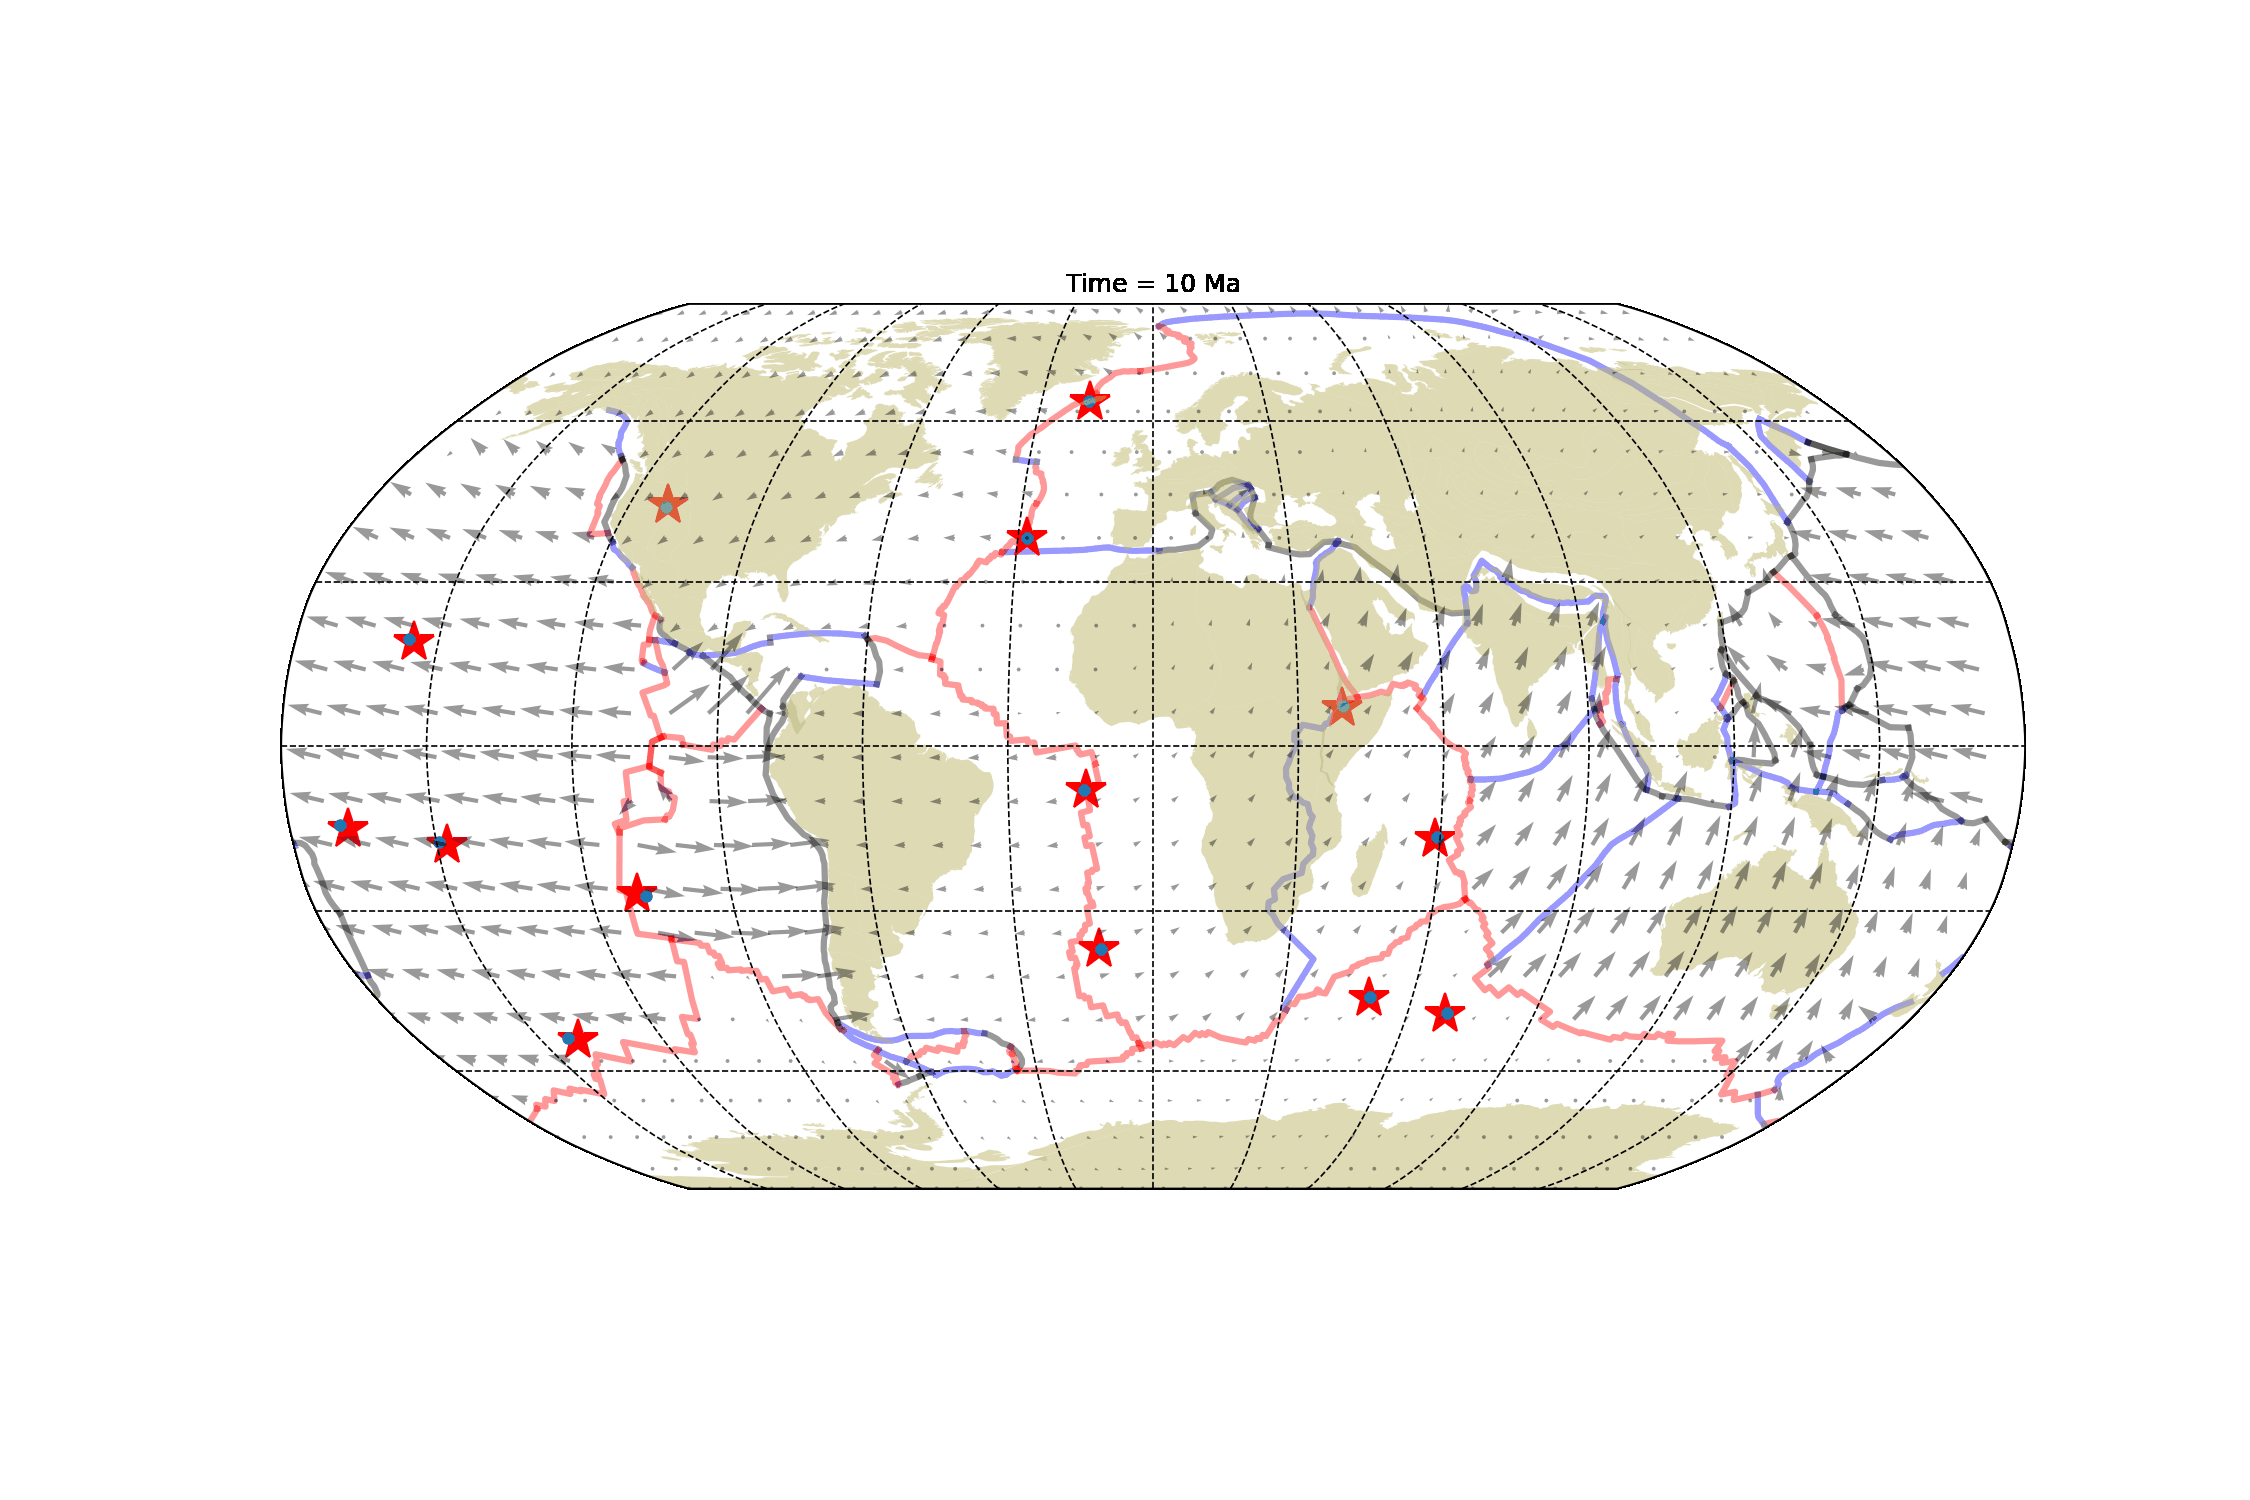

In [19]:
from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/hotspot_trails.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

In [8]:
print('Done!')

Done!
